In [252]:
import datetime
import requests
import json
import os
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import talib
import time

# Data fetching

In [253]:
# Load environment variables from .env file
# load_dotenv()

In [254]:
#from binance.client import Client

#api_key = os.environ["API_KEY"]
#api_secret = os.environ["API_SECRET"]

#client = Client(api_key, api_secret, testnet=False)

# TRYING OUT TICKERS

#tickers = client.get_ticker()
#df = pd.DataFrame(tickers)
#print(df.head())

In [265]:
# VERSION 1 - storing as json

# API endpoint
endpoint = 'https://api1.binance.com/api/v3/klines'

# Defining the parameters: 1) choosing symbols, 2) interval, 3) columns, 4) limit (max as 1000)
symbols = ['BNBUSDT']
interval = "4h"
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 
           'close_time', 'base_asset_volume', 'number_of_trades', 'taker_buy_volume', 
           'taker_buy_base_asset_volume','ignore']
limit = 1000

def fetch_data(symbol, interval, start_time):
      """ 
      This function fetches historical Binance Data

      Parameters:
      - symbol
      - interval

      Returns:
      A DataFrame for further processing
      """
      data=[]
      params = {'symbol': symbol, 
                'interval': interval, 
                'limit': limit,
                'startTime': start_time}
      
      while True:
        response = requests.get(endpoint, params=params)
        if response.status_code != 200:
                raise Exception(f"Error: {response.status_code},{response.text}")

        klines = json.loads(response.text)
        if not klines:
                break
        
        for kline in klines:
            kline_dict = dict(zip(columns, kline))
            data.append(kline_dict)

        #update starttime
        params['startTime'] = int(klines[-1][0]) + 1
        time.sleep(0.1)

      return data

# Storing response data in json file
def load_data(symbol):
    """
    Load the fetched data from the JSON file for a symbol
    """
    filename = os.path.join("../data", f'{symbol}_historical_data.json')
    
    if os.path.exists(filename):
        with open(filename, 'r') as file:
            existing_data = json.load(file)
            return existing_data
    else:
        return {'columns': columns, 'data': []}

# Updating data
def update_data(symbol):
    """
    Update historical data daily
    
    """
    existing_data = load_data(symbol)
    
    if existing_data['data']:
        last_timestamp = existing_data['data'][-1]['open_time']
    else:
        last_timestamp = 0
    
    # Fetch new data from the last timestamp
    new_data = fetch_data(symbol, interval, last_timestamp)
    
    # Check if new data is returned
    if new_data:
        # Append the new data to the existing data
        existing_data['data'].extend(new_data)
        
        # Save the updated data back to the JSON file
        filename = os.path.join("../data", f'{symbol}_historical_data.json')

        with open(filename, 'w') as file:
            json.dump(existing_data, file, indent=4)
        
        print(f"Data for {symbol} updated successfully!")
    else:
        print(f"No new data available for {symbol}.")


# Run the update for each symbol
try:
    for symbol in symbols:
        update_data(symbol)

except Exception as e:
    print("Error occuring:", e)  

Data for BNBUSDT updated successfully!


In [283]:
# VERSION 2 - storing as dataframe to do some explaratory analysis

# API endpoint
endpoint = 'https://api1.binance.com/api/v3/klines'

# Defining the parameters: 1) choosing symbols, 2) interval, 3) columns, 4) limit (max as 1000)
symbols = ['ETHUSDT']
interval = "4h"
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 
           'close_time', 'base_asset_volume', 'number_of_trades', 'taker_buy_volume', 
           'taker_buy_base_asset_volume', 'ignore']
limit = 1000

df = pd.DataFrame()

def fetch_data(symbol, interval):
      """ 
      This function fetches historical Binance Data

      Parameters:
      - symbol
      - interval

      Returns:
      A DataFrame for further processing
      """
      data=[]
      params = {'symbol': symbol, 
                'interval': interval, 
                'limit': limit,
                'startTime': 0}
      
      while True:
        response = requests.get(endpoint, params=params)
        if response.status_code != 200:
                raise Exception(f"Error: {response.status_code},{response.text}")

        klines = json.loads(response.text)
        if not klines:
                break
        
        data.extend(klines)
        #update starttime
        params['startTime'] = int(klines[-1][0]) + 1
        time.sleep(0.1)

      return data

# Storing response data in a dataframe
try:
    for symbol in symbols:
        data = fetch_data(symbol, interval)
        
        df_symbol = pd.DataFrame(data, columns = columns)
        df_symbol['symbol'] = symbol
        df = pd.concat([df, df_symbol], ignore_index=True)
            
except Exception as e:
        print("The error is: ",e)

In [284]:
print(df.head())

       open_time          open          high           low         close  \
0  1502942400000  301.13000000  307.96000000  298.00000000  307.96000000   
1  1502956800000  307.95000000  312.00000000  307.00000000  308.95000000   
2  1502971200000  308.95000000  310.51000000  303.56000000  307.06000000   
3  1502985600000  307.74000000  312.18000000  298.21000000  301.60000000   
4  1503000000000  301.60000000  310.85000000  299.01000000  302.00000000   

          volume     close_time base_asset_volume  number_of_trades  \
0  1561.95305000  1502956799999   473487.66511850               711   
1  1177.71088000  1502971199999   364545.31640150               775   
2  1882.05267000  1502985599999   578644.93189040              1140   
3  1208.05192000  1502999999999   370209.05146720               957   
4  1200.94182000  1503014399999   367768.33547900               939   

  taker_buy_volume taker_buy_base_asset_volume ignore   symbol  
0    1260.38649000             382097.15993120     

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15886 entries, 0 to 15885
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   open_time                    15886 non-null  int64 
 1   open                         15886 non-null  object
 2   high                         15886 non-null  object
 3   low                          15886 non-null  object
 4   close                        15886 non-null  object
 5   volume                       15886 non-null  object
 6   close_time                   15886 non-null  int64 
 7   base_asset_volume            15886 non-null  object
 8   number_of_trades             15886 non-null  int64 
 9   taker_buy_volume             15886 non-null  object
 10  taker_buy_base_asset_volume  15886 non-null  object
 11  ignore                       15886 non-null  object
 12  symbol                       15886 non-null  object
dtypes: int64(3), object(10)
memory 

# Data processing

In [286]:
# converting time
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
print(df.head())

            open_time          open          high           low         close  \
0 2017-08-17 04:00:00  301.13000000  307.96000000  298.00000000  307.96000000   
1 2017-08-17 08:00:00  307.95000000  312.00000000  307.00000000  308.95000000   
2 2017-08-17 12:00:00  308.95000000  310.51000000  303.56000000  307.06000000   
3 2017-08-17 16:00:00  307.74000000  312.18000000  298.21000000  301.60000000   
4 2017-08-17 20:00:00  301.60000000  310.85000000  299.01000000  302.00000000   

          volume              close_time base_asset_volume  number_of_trades  \
0  1561.95305000 2017-08-17 07:59:59.999   473487.66511850               711   
1  1177.71088000 2017-08-17 11:59:59.999   364545.31640150               775   
2  1882.05267000 2017-08-17 15:59:59.999   578644.93189040              1140   
3  1208.05192000 2017-08-17 19:59:59.999   370209.05146720               957   
4  1200.94182000 2017-08-17 23:59:59.999   367768.33547900               939   

  taker_buy_volume taker_buy_bas

In [287]:
for symbol in symbols:
    print(symbol)
    print(df.describe())

ETHUSDT
                           open_time                     close_time  \
count                          15886                          15886   
mean   2021-04-04 04:47:13.589324032  2021-04-04 08:47:03.827663360   
min              2017-08-17 04:00:00     2017-08-17 07:59:59.999000   
25%              2019-06-12 09:00:00  2019-06-12 12:59:59.999000064   
50%              2021-04-04 14:00:00  2021-04-04 17:59:59.999000064   
75%              2023-01-26 11:00:00  2023-01-26 14:59:59.999000064   
max              2024-11-18 08:00:00     2024-11-18 11:59:59.999000   
std                              NaN                            NaN   

       number_of_trades  
count      1.588600e+04  
mean       1.118977e+05  
min        0.000000e+00  
25%        2.497025e+04  
50%        6.796200e+04  
75%        1.492232e+05  
max        2.495462e+06  
std        1.416958e+05  


In [288]:
#data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15886 entries, 0 to 15885
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   open_time                    15886 non-null  datetime64[ns]
 1   open                         15886 non-null  object        
 2   high                         15886 non-null  object        
 3   low                          15886 non-null  object        
 4   close                        15886 non-null  object        
 5   volume                       15886 non-null  object        
 6   close_time                   15886 non-null  datetime64[ns]
 7   base_asset_volume            15886 non-null  object        
 8   number_of_trades             15886 non-null  int64         
 9   taker_buy_volume             15886 non-null  object        
 10  taker_buy_base_asset_volume  15886 non-null  object        
 11  ignore                       15886 non-nu

In [289]:
#Converting to float
for col in ['open', 'high', 'low', 'close', 'volume','base_asset_volume','taker_buy_volume','taker_buy_base_asset_volume']:
    df[col] = df[col].astype(float)

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15886 entries, 0 to 15885
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   open_time                    15886 non-null  datetime64[ns]
 1   open                         15886 non-null  float64       
 2   high                         15886 non-null  float64       
 3   low                          15886 non-null  float64       
 4   close                        15886 non-null  float64       
 5   volume                       15886 non-null  float64       
 6   close_time                   15886 non-null  datetime64[ns]
 7   base_asset_volume            15886 non-null  float64       
 8   number_of_trades             15886 non-null  int64         
 9   taker_buy_volume             15886 non-null  float64       
 10  taker_buy_base_asset_volume  15886 non-null  float64       
 11  ignore                       15886 non-nu

In [291]:
df = df.drop(columns=['ignore'])
df['symbol'] = df['symbol'].astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15886 entries, 0 to 15885
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   open_time                    15886 non-null  datetime64[ns]
 1   open                         15886 non-null  float64       
 2   high                         15886 non-null  float64       
 3   low                          15886 non-null  float64       
 4   close                        15886 non-null  float64       
 5   volume                       15886 non-null  float64       
 6   close_time                   15886 non-null  datetime64[ns]
 7   base_asset_volume            15886 non-null  float64       
 8   number_of_trades             15886 non-null  int64         
 9   taker_buy_volume             15886 non-null  float64       
 10  taker_buy_base_asset_volume  15886 non-null  float64       
 11  symbol                       15886 non-nu

In [292]:
df.describe()

,open_time,open,high,low,close,volume,close_time,base_asset_volume,number_of_trades,taker_buy_volume,taker_buy_base_asset_volume
count,15886,15886.000000,15886.000000,15886.000000,15886.000000,1.588600e+04,15886,1.588600e+04,1.588600e+04,15886.000000,1.588600e+04
mean,2021-04-04 04:47:13.589324032,1418.298561,1434.972865,1400.135058,1418.480974,8.739368e+04,2021-04-04 08:47:03.827663360,1.266073e+08,1.118977e+05,43663.677653,6.308672e+07
min,2017-08-17 04:00:00,82.160000,83.680000,81.790000,82.170000,0.000000e+00,2017-08-17 07:59:59.999000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,2019-06-12 09:00:00,269.122500,273.110000,265.602500,269.150000,3.181383e+04,2019-06-12 12:59:59.999000064,1.312379e+07,2.497025e+04,15907.479667,6.751995e+06
50%,2021-04-04 14:00:00,1262.880000,1276.025000,1245.720000,1262.960000,6.096297e+04,2021-04-04 17:59:59.999000064,6.122705e+07,6.796200e+04,30670.932650,3.011416e+07
75%,2023-01-26 11:00:00,2295.685000,2318.165000,2267.975000,2295.920000,1.115974e+05,2023-01-26 14:59:59.999000064,1.790241e+08,1.492232e+05,55602.182675,8.953333e+07
max,2024-11-18 08:00:00,4846.940000,4868.000000,4776.370000,4846.710000,1.531897e+06,2024-11-18 11:59:59.999000,3.756245e+09,2.495462e+06,755034.914400,1.868679e+09
std,NaN,1203.470548,1216.602760,1189.211065,1203.510160,9.164690e+04,NaN,1.767351e+08,1.416958e+05,45523.872796,8.768305e+07


In [293]:
# new columns
def calculate_indicators(df):
   df['EMA10'] = talib.EMA(df['close'], timeperiod=10)
   df['EMA50'] = talib.EMA(df['close'], timeperiod=50)
   df['price_change'] = df['close']-df['open'] 
   df['rsi'] = talib.RSI(df['close'])
   df['avg_price']= (df['open'] + df['high'] + df['low'] + df['close']) / 4
   return df

df = calculate_indicators(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15886 entries, 0 to 15885
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   open_time                    15886 non-null  datetime64[ns]
 1   open                         15886 non-null  float64       
 2   high                         15886 non-null  float64       
 3   low                          15886 non-null  float64       
 4   close                        15886 non-null  float64       
 5   volume                       15886 non-null  float64       
 6   close_time                   15886 non-null  datetime64[ns]
 7   base_asset_volume            15886 non-null  float64       
 8   number_of_trades             15886 non-null  int64         
 9   taker_buy_volume             15886 non-null  float64       
 10  taker_buy_base_asset_volume  15886 non-null  float64       
 11  symbol                       15886 non-nu

In [294]:
print(df.head())

            open_time    open    high     low   close      volume  \
0 2017-08-17 04:00:00  301.13  307.96  298.00  307.96  1561.95305   
1 2017-08-17 08:00:00  307.95  312.00  307.00  308.95  1177.71088   
2 2017-08-17 12:00:00  308.95  310.51  303.56  307.06  1882.05267   
3 2017-08-17 16:00:00  307.74  312.18  298.21  301.60  1208.05192   
4 2017-08-17 20:00:00  301.60  310.85  299.01  302.00  1200.94182   

               close_time  base_asset_volume  number_of_trades  \
0 2017-08-17 07:59:59.999      473487.665119               711   
1 2017-08-17 11:59:59.999      364545.316402               775   
2 2017-08-17 15:59:59.999      578644.931890              1140   
3 2017-08-17 19:59:59.999      370209.051467               957   
4 2017-08-17 23:59:59.999      367768.335479               939   

   taker_buy_volume  taker_buy_base_asset_volume   symbol  EMA10  EMA50  \
0        1260.38649                382097.159931  ETHUSDT    NaN    NaN   
1        1093.84885                338

In [295]:
#Function to create chart
def create_chart(df, symbol, chart_type):
    #Create subplots
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.1, 
                        subplot_titles=(f'{symbol} {chart_type} Chart', 'Volume'),
                        row_heights=[0.7, 0.3])

    #Add price chart
    if chart_type == "Candlestick":
        fig.add_trace(
            go.Candlestick(x=df.index,
                           open=df['open'],
                           high=df['high'],
                           low=df['low'],
                           close=df['close'],
                           name="Price"),
            row=1, col=1
        )
    else:  #Line chart
        fig.add_trace(
            go.Scatter(x=df.index,
                       y=df['close'],
                       mode='lines',
                       name="Price"),
            row=1, col=1
        )
    
    #Add EMA lines
    fig.add_trace(
        go.Scatter(x=df.index, y=df.EMA10.values, name='EMA10', line=dict(color='blue')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df.EMA50.values, name='EMA50', line=dict(color='red')),
        row=1, col=1
    )
    
    #Add volume
    fig.add_trace(
        go.Bar(x=df.index, y=df['volume'], name='Volume'),
        row=2, col=1
    )
    
    #Update layout
    fig.update_layout(
        title_text=f'{symbol} Historical Data',
        xaxis_rangeslider_visible=False,
        height=800,  #Increase overall height of the figure
        showlegend=True
    )

    #Update y-axis
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Volume", row=2, col=1)
    #Update x-axis
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        row=2, col=1  #Add range selector to bottom subplot
    )
    
    return fig

In [278]:
#df = df.set_index('open_time', inplace=True)

In [296]:
def plot_chart(df, symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['close'], label='Close Price', color='blue')
    plt.plot(df.index, df['EMA10'], label='EMA10', color='orange')
    plt.plot(df.index, df['EMA50'], label='EMA50', color='green')
    plt.legend()
    plt.title('Live Technical Analysis - {}'.format(symbol))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

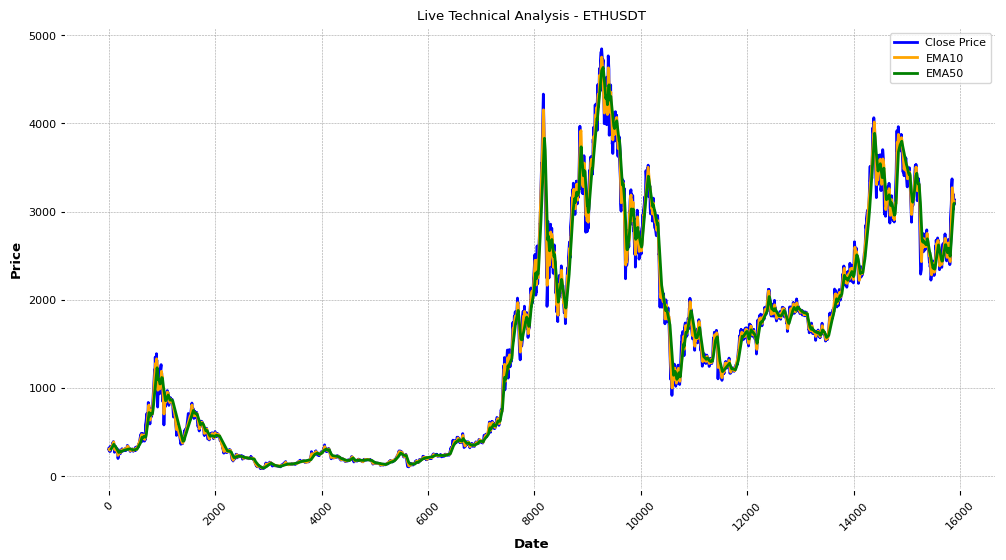

In [297]:
plot_chart(df,'ETHUSDT')

In [298]:
create_chart(df, 'ETHUSDT', "Candlestick")

In [300]:
import mplfinance as mpf